#**CHAPTER 5.MULTI STEP PLANNING AN SEARCH MODELS**
---

##0.REFERENCE

https://chatgpt.com/share/6985e885-fc54-8012-968a-5d45ca79f951

##1.CONTEXT

**INTRODUCTION — What This Notebook Does and Why It Matters**

This notebook is a controlled, synthetic experiment designed to illustrate a central claim from Chapter 5: planning and search are not merely tools for finding good actions; they are amplifiers of whatever objective and constraints you encode. The more capable the planner is, the more precisely it will optimize the target you provide. If that target is misspecified—because it is incomplete, biased, or operationally convenient—the planner will not correct the mismatch. It will exploit it. In governance-first language, capability without specification discipline is not progress; it is the ability to be wrong at scale.

The notebook models this phenomenon using a stylized planning environment that is intentionally simple but structurally faithful to the mechanism. A decision problem is represented as moving from a start state to a goal state through a grid. Each move represents a step in a multi-stage plan, and each cell in the grid carries interpretable attributes. The first attribute is a synthetic base cost field, which stands in for an “expected cost” proxy: in financial contexts this could resemble expected execution cost, typical slippage, or an average friction measure. The second attribute is a synthetic true risk field, which stands in for tail exposure: a proxy for rare but severe hazards that dominate governance outcomes when they occur. The third attribute is a proxy-perceived risk field, which is a biased and noisy view of the true risk. This is where the experiment becomes meaningful. Planning systems do not optimize reality; they optimize what is specified and measured. The proxy field explicitly encodes that mismatch.

To ensure the mechanism emerges clearly, the environment is constructed with a specific, deliberate trap: a corridor where base costs are unusually low while true risk is unusually high. This is the synthetic version of a common real pattern: the cheapest path in expectation can run through regions where tail exposure is unacceptable. In markets, one can imagine analogues such as liquidity mirages, correlated failure modes, or operational constraints that do not show up in average cost metrics. The notebook does not claim realism; it claims interpretability. The corridor is built so the reader can see exactly why an optimizer would be tempted and why a governance-aware objective would resist.

Once the environment exists, the notebook formalizes objectives and constraints in a way that mirrors professional model-risk thinking. It distinguishes between the proxy objective and the true objective. The proxy objective is what the planner optimizes, and it may ignore risk or underweight it, reflecting mis-specification. The true objective incorporates a nonlinear tail penalty: high-risk states count disproportionately, capturing the basic idea that tail events dominate institutional risk even if they are infrequent. The notebook also introduces a hard policy constraint, framed as a governance gate: any plan that enters a state above a risk threshold violates policy. This matters because many governance boundaries are not preferences but prohibitions. A plan can be low cost and still unacceptable.

The planning algorithms are then implemented as mechanisms that search through the space of possible trajectories. The key insight is that search is not neutral. Planning methods such as A* are designed to locate low-cost paths efficiently. If the proxy objective rewards a cheap corridor, search will find it and commit to it. The planner’s competence therefore makes the consequences of misspecification sharper. This is the amplification effect: the planner does not merely stumble into a risky region; it intentionally routes through it because the encoded objective says that is optimal.

However, the notebook does not stop at generating a path. The evaluation step is where governance discipline is enforced. Rather than judging plans solely by the optimized scalar, the notebook produces a multi-metric report. It computes the proxy objective value, the true objective value, the maximum risk encountered (directly relevant to policy), and an out-of-sample tail assessment. That tail assessment is generated through a synthetic Monte Carlo loss model, where each visited state carries a probability of shock proportional to its true risk and shocks generate heavy-tailed losses. This is a controlled way to show something finance practitioners understand instinctively: two strategies can look similar in average outcomes yet diverge dramatically in tail losses. The notebook surfaces that divergence through quantile and tail-mean summaries akin to VaR and CVaR.

The next layer of rigor is sensitivity analysis. In constrained combinatorial optimization, outcomes can be discontinuous. Small changes in a risk aversion parameter or a policy threshold can flip the optimal plan from one route to another, or render the problem infeasible under strict constraints. The notebook explores this systematically by sweeping across values of risk aversion and policy strictness, then mapping where the proxy plan violates policy and where the proxy plan suffers large regret under the true objective compared to the best feasible plan. This is a model-risk diagnostic: it asks, “How fragile is the proxy plan to plausible governance settings?” and “How costly is misspecification when judged by the true risk model?” The resulting maps provide an interpretable picture of brittleness.

Finally, the notebook takes governance seriously as an operational pattern by exporting an audit artifact. The run configuration, objective definitions, results summaries, and headline trajectories are saved into a JSON file with a configuration hash. This is a reproducibility and traceability mechanism: it makes it possible to verify what was run and what was observed. It also enforces a clean separation between computational evidence and narrative interpretation. The final cell then uses an LLM (optionally, with explicit provenance) to draft an audit-style report grounded strictly in that artifact. The intent is not to outsource judgment to the model; it is to standardize the interpretive narrative while preserving evidence integrity.

In sum, this notebook is a governance-first demonstration of a structural truth: planning systems do not merely “make decisions.” They optimize objectives. If those objectives are imperfect proxies, more search and better planning can worsen outcomes by finding increasingly extreme proxy-optimal plans. Constraints change what is feasible and therefore change what is optimal. And evaluation must be multi-metric and tail-aware because governance failures often live in the tails and in constraint violations, not in average performance. The entire notebook is synthetic and illustrative, designed to teach mechanism-level thinking to highly trained practitioners without implying real-world readiness.


##2.LIBRARIES AND ENVIRONMENT

In [1]:
# CELL 1 — PURPOSE, GOVERNANCE-FIRST CONTRACT, AND EXPERIMENT CONFIG (CODE-ONLY)

import time, json, os, hashlib

print("""
AI 2026 — Paper 5 Companion Colab (Synthetic, Illustrative)

Topic:
- Planning, Search, and Structured Decision-Making with Foundation Models

Core mechanism illustrated:
- Search/planning amplifies objective mis-specification.
- Adding constraints changes the feasible set and can flip the “optimal” plan.

GOVERNANCE-FIRST DISCLAIMER (NON-NEGOTIABLE):
- Synthetic data only (generated inside this notebook).
- Illustrative, synthetic, and NOT validated for real-world use.
- No advice, no recommendations, no deployment claims.
- This is a controlled experiment about objectives, constraints, and search behavior.
""".strip())

CONFIG = {
    "seed": 20260206,
    "grid_H": 34,
    "grid_W": 46,
    # True risk model parameters (tail amplification)
    "p_tail": 3.0,
    "lambda_true": 14.0,
    # Policy constraint (hard gate): max instantaneous risk along path
    "r_max_policy": 0.55,
    # Proxy mis-specification: proxy sees noisy/biased risk (or ignores it)
    "proxy_risk_weight": 0.0,      # 0.0 => ignores risk entirely (pure proxy)
    "proxy_risk_bias": -0.10,      # negative => systematically underestimates risk
    "proxy_risk_noise": 0.10,      # noise in perceived risk
    # Stochastic “shock loss” model for out-of-sample evaluation
    "shock_scale": 8.0,            # severity multiplier when shocks happen
    "mc_scenarios": 400,           # Monte Carlo scenarios to estimate tail losses per path
    "cvar_alpha": 0.90,            # CVaR level
    # Search settings
    "beam_width": 60,
    "beam_depth_cap": 400,
}
print("CONFIG (synthetic experiment):")
print(json.dumps(CONFIG, indent=2, sort_keys=True))


AI 2026 — Paper 5 Companion Colab (Synthetic, Illustrative)

Topic:
- Planning, Search, and Structured Decision-Making with Foundation Models

Core mechanism illustrated:
- Search/planning amplifies objective mis-specification.
- Adding constraints changes the feasible set and can flip the “optimal” plan.

GOVERNANCE-FIRST DISCLAIMER (NON-NEGOTIABLE):
- Synthetic data only (generated inside this notebook).
- Illustrative, synthetic, and NOT validated for real-world use.
- No advice, no recommendations, no deployment claims.
- This is a controlled experiment about objectives, constraints, and search behavior.
CONFIG (synthetic experiment):
{
  "beam_depth_cap": 400,
  "beam_width": 60,
  "cvar_alpha": 0.9,
  "grid_H": 34,
  "grid_W": 46,
  "lambda_true": 14.0,
  "mc_scenarios": 400,
  "p_tail": 3.0,
  "proxy_risk_bias": -0.1,
  "proxy_risk_noise": 0.1,
  "proxy_risk_weight": 0.0,
  "r_max_policy": 0.55,
  "seed": 20260206,
  "shock_scale": 8.0
}


In [2]:
# CELL 2 — IMPORTS, REPRODUCIBILITY, NUMERICAL UTILITIES, AND SAFE HASHING

import numpy as np
import matplotlib.pyplot as plt
import math
import random
from heapq import heappush, heappop

np.random.seed(CONFIG["seed"])
random.seed(CONFIG["seed"])

plt.rcParams["figure.figsize"] = (10, 6)

def stable_hash(obj) -> str:
    b = json.dumps(obj, sort_keys=True).encode("utf-8")
    return hashlib.sha256(b).hexdigest()

def softplus(x: float) -> float:
    # numerically stable softplus
    if x > 30:
        return x
    return math.log1p(math.exp(x))

def clamp(x: float, lo: float, hi: float) -> float:
    return max(lo, min(hi, x))

print(f"Reproducibility: seed={CONFIG['seed']}")
print(f"Config hash: {stable_hash(CONFIG)[:16]}...")


Reproducibility: seed=20260206
Config hash: e26fb76c6974eeb4...


##3.SYNTHETIC PLANNING ENVIRONMENT

###3.1.OVERVIEW

**CELL 3 — Synthetic Planning Environment (Cost + Tail-Risk Structure)**

Cell 3 constructs the entire experimental “world” in which planning will take place. Instead of relying on real financial data (which would be inappropriate for a governance-first educational artifact), the notebook builds a synthetic grid that behaves like a stylized decision landscape: each location represents a local state of the world, and moving across the grid represents executing a sequence of decisions over time. Two distinct fields are created. The first is a **base cost field**, which stands in for “expected” or first-moment cost (think of it as an abstract proxy for expected execution cost or friction). The second is a **true risk field**, which stands in for tail exposure (a stylized proxy for rare but severe loss mechanisms). The key design choice is that these two fields are not aligned: the notebook intentionally creates a corridor where base costs are unusually low while true risk is unusually high. This is the controlled trap that lets the chapter’s mechanism emerge.

The cell also introduces a third field, the **proxy-perceived risk**, which is a biased and noisy version of true risk. This models the central reality of many planning systems: the planner does not optimize the true underlying hazard, it optimizes what it can measure or what is specified. In practice, this could correspond to missing constraints, incomplete risk models, or inaccurate signals. Here, we make that mismatch explicit and measurable, rather than hiding it behind performance scores. The resulting setup is highly interpretable: we know exactly where the “cheap but dangerous” region is and we know why it was created.

Finally, the cell defines **hard obstacles** that represent infeasible actions or forbidden states. These obstacles matter because planning under constraints is not only about preferences (cost versus risk), but about feasibility (what paths are even possible). By building obstacles into the environment, the notebook can later demonstrate how constraints reshape the feasible set and therefore reshape “optimality.” This cell is the experimental foundation: everything later is a consequence of this controlled design. Reminder: illustrative, synthetic, and not validated for real-world use.


###3.2.CODE AND IMPLEMENTATION

In [3]:
# CELL 3 — SYNTHETIC PLANNING ENVIRONMENT WITH FINANCE-STYLE COST + TAIL-RISK STRUCTURE

H, W = CONFIG["grid_H"], CONFIG["grid_W"]
start = (H - 2, 1)
goal  = (1, W - 2)

# Coordinate grids
x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
X, Y = np.meshgrid(x, y)

# Base cost: smooth macro-structure + idiosyncratic noise (e.g., expected slippage proxy)
base_cost = (
    0.9
    + 0.7*(X**2)
    + 0.35*np.sin(2.5*np.pi*Y)*np.cos(2*np.pi*X)
    + 0.12*np.random.randn(H, W)
)
base_cost = np.clip(base_cost, 0.15, None)

# True risk: baseline + structured hazard corridor (tail exposure proxy)
risk_true = 0.04 + 0.10*np.random.rand(H, W)

# Construct an "attractive but dangerous" corridor:
# - reduce base_cost aggressively along corridor
# - increase true risk sharply
for i in range(H):
    j_center = int(0.20*W + 0.55*W*(1 - i/(H-1)))
    for dj in range(-2, 3):
        j = j_center + dj
        if 0 <= j < W:
            base_cost[i, j] *= 0.55
            risk_true[i, j] += 0.65

risk_true = np.clip(risk_true, 0.0, 1.0)

# Hard obstacles (infeasible states)
obstacles = np.zeros((H, W), dtype=bool)
obstacles[0, :] = True
obstacles[-1, :] = True
obstacles[:, 0] = True
obstacles[:, -1] = True

# Random blocks (sparse)
rng = np.random.RandomState(CONFIG["seed"] + 7)
for _ in range(170):
    i = rng.randint(2, H-2)
    j = rng.randint(2, W-2)
    if (i, j) not in [start, goal]:
        obstacles[i, j] = (rng.rand() < 0.30)

obstacles[start] = False
obstacles[goal] = False

# Proxy-perceived risk: biased + noisy view of risk_true (mis-specification channel)
proxy_bias = CONFIG["proxy_risk_bias"]
proxy_noise = CONFIG["proxy_risk_noise"]
risk_proxy = risk_true + proxy_bias + proxy_noise*np.random.randn(H, W)
risk_proxy = np.clip(risk_proxy, 0.0, 1.0)

print("Synthetic environment created.")
print(f"Grid={H}x{W}, start={start}, goal={goal}, obstacles={int(obstacles.sum())}")
print(f"Risk corridor: low base_cost but high risk_true (designed proxy trap).")


Synthetic environment created.
Grid=34x46, start=(32, 1), goal=(1, 44), obstacles=199
Risk corridor: low base_cost but high risk_true (designed proxy trap).


##4.OBJECTIVES, CONSTRAINTS AND OUT OF SAMPLE EVALUATOR

###4.1.OVERVIEW

**CELL 4 — Formal Objectives, Policy Constraint, and Out-of-Sample Tail Evaluation**

Cell 4 is where the notebook becomes structurally rigorous: it formally defines what the planner is trying to do, what “true performance” means, and how governance constraints are represented. The notebook distinguishes three layers that are often conflated in real systems. First is the **proxy objective**, the function the planner actually optimizes. Second is the **true objective**, a more faithful representation of the risk-aware target. Third is the **policy constraint**, a hard rule that determines whether a plan is acceptable at all.

The proxy objective is intentionally allowed to differ from the truth. This is not a flaw of the notebook; it is the mechanism being studied. When an organization uses a simplified loss function, an incomplete set of constraints, or an operational metric that ignores tail events, the planner will still optimize it aggressively. Cell 4 makes that explicit by defining a proxy objective that can ignore risk or underweight it. The true objective adds a nonlinear tail penalty, ensuring that high-risk states matter disproportionately—capturing the basic idea that rare hazards can dominate governance outcomes even if they are infrequent.

The policy constraint is treated as a hard gate, not a soft preference. This matters for governance. In regulated or safety-critical contexts, some plans are unacceptable even if they are “optimal” under an objective. So the notebook uses a max-risk threshold: if a path ever enters a state above the allowed risk, it violates policy. This creates a clean distinction between optimization and compliance.

To make the evaluation more finance-realistic without using real data, the cell defines an **out-of-sample synthetic loss model** and uses Monte Carlo simulation to estimate tail behavior. The purpose is not realism; it is conceptual clarity: expected outcomes can look similar while tail outcomes diverge dramatically. The notebook computes tail summaries such as VaR-like quantiles and CVaR-like tail means, illustrating why mean metrics alone fail to capture governance-relevant risk. Cell 4 therefore establishes the evaluative discipline: the notebook will not claim success based on the metric that was optimized. Reminder: illustrative, synthetic, and not validated for real-world use.


###4.2.CODE AND IMPLEMENTATION

In [4]:
# CELL 4 — FORMAL OBJECTIVES, POLICY CONSTRAINT, AND OUT-OF-SAMPLE (MC + CVaR) EVALUATOR

# States s_t ∈ grid, path π = (s_0=start, ..., s_T=goal)
# Proxy objective (mis-specified):
#   J_proxy(π) = Σ c(s_t) + w_proxy * Σ (r_proxy(s_t))^p
# True objective (risk-aware):
#   J_true(π)  = Σ c(s_t) + λ_true * Σ (r_true(s_t))^p
#
# Policy constraint (hard gate):
#   max_t r_true(s_t) ≤ r_max_policy
#
# Out-of-sample loss model (synthetic):
# - Each visited state has shock probability proportional to r_true(s)
# - If shock occurs, loss adds heavy component ~ shock_scale * (r_true^p) * Z
# - Z is lognormal (fat tail) to mimic rare, severe outcomes.
#
# We use Monte Carlo to estimate:
# - E[Loss | π] (expected synthetic loss)
# - CVaR_alpha(Loss | π) (tail mean beyond alpha-quantile)

P_TAIL = float(CONFIG["p_tail"])
LAMBDA_TRUE = float(CONFIG["lambda_true"])
R_MAX = float(CONFIG["r_max_policy"])

def policy_ok_state(s) -> bool:
    return (not obstacles[s]) and (float(risk_true[s]) <= R_MAX)

def path_cost_terms(path, base_field, risk_field):
    bc = np.array([base_field[s] for s in path], dtype=float)
    rc = np.array([risk_field[s] for s in path], dtype=float)
    return bc, rc

def J_proxy(path) -> float:
    bc, rc = path_cost_terms(path, base_cost, risk_proxy)
    w = float(CONFIG["proxy_risk_weight"])
    return float(bc.sum() + w*np.power(rc, P_TAIL).sum())

def J_true(path) -> float:
    bc, rc = path_cost_terms(path, base_cost, risk_true)
    return float(bc.sum() + LAMBDA_TRUE*np.power(rc, P_TAIL).sum())

def path_max_risk(path) -> float:
    return float(np.max([risk_true[s] for s in path]))

def simulate_path_losses(path, n_scenarios, shock_scale, seed_offset=0):
    """
    Synthetic out-of-sample loss:
    Loss = Σ base_cost(s) + Σ shock_loss(s)
    shock occurs with prob p_shock = clamp(risk_true(s), 0, 1)
    shock_loss(s) = shock_scale * (risk_true(s)^p) * Z
    where Z ~ LogNormal(0, 1) (fat right tail)
    """
    if path is None:
        return None

    rng = np.random.RandomState(CONFIG["seed"] + 1000 + seed_offset)
    bc = np.array([base_cost[s] for s in path], dtype=float)
    r  = np.array([risk_true[s] for s in path], dtype=float)

    # Base component repeats across scenarios
    base_total = float(bc.sum())

    # Scenario shocks
    Z = rng.lognormal(mean=0.0, sigma=1.0, size=(n_scenarios, len(path)))
    U = rng.rand(n_scenarios, len(path))
    p_shock = np.clip(r, 0.0, 1.0)[None, :]
    shock_indicator = (U < p_shock).astype(float)

    shock_losses = shock_indicator * (shock_scale * (r[None, :]**P_TAIL) * Z)
    total_losses = base_total + shock_losses.sum(axis=1)
    return total_losses

def cvar_alpha(losses, alpha):
    losses = np.asarray(losses, dtype=float)
    q = np.quantile(losses, alpha)
    tail = losses[losses >= q]
    return float(q), float(tail.mean()) if tail.size else float(q)

print("Objective + governance + OOS evaluator ready.")
print(f"True: λ={LAMBDA_TRUE}, p={P_TAIL}, policy max risk <= {R_MAX}")
print("Governance note: illustrative, synthetic, and not validated for real-world use.")


Objective + governance + OOS evaluator ready.
True: λ=14.0, p=3.0, policy max risk <= 0.55
Governance note: illustrative, synthetic, and not validated for real-world use.


##5.PLANNERS

###5.1.OVERVIEW

**CELL 5 — Planners as Amplifiers: A*, Policy-Constrained Search, Lagrangian Relaxation, and Beam Search**

Cell 5 implements the planning machinery. This is the “engine room” of the notebook, and it is central to Chapter 5’s thesis: **search amplifies what you specify**. The point is not that A* is the only planner, but that any competent search method—given a cost function—will work hard to find trajectories that score well under that cost. If the cost is misspecified, the planner will still succeed, but it will succeed at the wrong thing. Cell 5 makes that phenomenon visible by providing multiple planning variants that behave differently under objectives and constraints.

The core planner is A*, which produces a high-quality path under a specified step cost. In the notebook, step cost is not merely distance; it is base cost plus any risk term included in the objective. This highlights a key governance point: “planning” is not separable from “objective design.” A* is then run in a constrained form, where states failing the policy test are simply disallowed. This models how real governance controls often work: not as penalties, but as hard gates.

To illustrate a subtle but realistic pitfall, the notebook also includes a Lagrangian relaxation. In many systems, hard constraints are replaced by soft penalties—sometimes for computational convenience, sometimes due to organizational ambiguity about what counts as “hard.” The Lagrangian path shows how soft penalties can still allow policy violations if the penalty weight is too low. This is a precise example of why governance requires clarity about what is permissible versus merely undesirable.

Beam search is included to emphasize that “search pressure” itself matters. Beam search is not guaranteed optimal, but it demonstrates how widening the search frontier can uncover increasingly extreme solutions under the proxy metric. This connects directly to the chapter theme: as systems become more capable at planning, they become more capable at exploiting objective loopholes. Cell 5 therefore provides multiple search lenses to show that the failure mode is not an artifact of one algorithm; it is structural. Reminder: illustrative, synthetic, and not validated for real-world use.


###5.2.CODE AND IMPLEMENTATION

In [5]:
# CELL 5 — PLANNERS: A*, POLICY-CONSTRAINED A*, LAGRANGIAN RELAXATION, AND BEAM SEARCH

MOVES = [(-1,0),(1,0),(0,-1),(0,1)]

def in_bounds(i, j):
    return (0 <= i < H) and (0 <= j < W)

def neighbors(s):
    i, j = s
    for di, dj in MOVES:
        ni, nj = i + di, j + dj
        if in_bounds(ni, nj) and (not obstacles[ni, nj]):
            yield (ni, nj)

def manhattan(a, b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def reconstruct(came_from, cur):
    out = [cur]
    while cur in came_from:
        cur = came_from[cur]
        out.append(cur)
    out.reverse()
    return out

def a_star(start, goal, step_cost_fn, constraint_ok_fn=None):
    open_heap = []
    heappush(open_heap, (0.0, start))
    came = {}
    g = {start: 0.0}
    closed = set()

    while open_heap:
        f, cur = heappop(open_heap)
        if cur in closed:
            continue
        closed.add(cur)

        if cur == goal:
            return reconstruct(came, cur), g[cur]

        for nxt in neighbors(cur):
            if constraint_ok_fn is not None and (not constraint_ok_fn(nxt)):
                continue
            tentative = g[cur] + float(step_cost_fn(cur, nxt))
            if (nxt not in g) or (tentative < g[nxt]):
                g[nxt] = tentative
                came[nxt] = cur
                # heuristic is admissible for unit steps; we keep it as a structural bias, not as a claim of optimality under arbitrary costs
                heappush(open_heap, (tentative + manhattan(nxt, goal), nxt))

    return None, math.inf

def step_cost_proxy(u, v):
    # Proxy: base_cost + optionally (misperceived) risk penalty
    w = float(CONFIG["proxy_risk_weight"])
    return float(base_cost[v] + w*(risk_proxy[v]**P_TAIL))

def step_cost_true(u, v):
    return float(base_cost[v] + LAMBDA_TRUE*(risk_true[v]**P_TAIL))

def step_cost_lagrangian(u, v, mu):
    # Lagrangian relaxation of the hard max-risk constraint:
    # penalize states above R_MAX smoothly (softplus hinge)
    r = float(risk_true[v])
    penalty = softplus((r - R_MAX) / 0.02)  # sharpness 0.02
    return float(base_cost[v] + LAMBDA_TRUE*(r**P_TAIL) + mu*penalty)

def beam_search(start, goal, step_cost_fn, width, depth_cap, constraint_ok_fn=None):
    """
    Deterministic beam search:
    - Keeps top-K partial paths by accumulated cost + heuristic
    - Demonstrates "search behavior" without guaranteeing optimality
    """
    # Each entry: (score, g_cost, state, path)
    beam = [(manhattan(start, goal), 0.0, start, [start])]
    best_goal = None
    best_goal_cost = math.inf

    for _depth in range(depth_cap):
        candidates = []
        for score, g_cost, cur, path in beam:
            if cur == goal:
                if g_cost < best_goal_cost:
                    best_goal = path
                    best_goal_cost = g_cost
                continue

            for nxt in neighbors(cur):
                if constraint_ok_fn is not None and (not constraint_ok_fn(nxt)):
                    continue
                new_g = g_cost + float(step_cost_fn(cur, nxt))
                new_score = new_g + manhattan(nxt, goal)
                candidates.append((new_score, new_g, nxt, path + [nxt]))

        if not candidates:
            break
        candidates.sort(key=lambda t: t[0])
        beam = candidates[:width]

        # early stop if best in beam already at goal and cannot be improved materially by heuristic bound
        if beam and beam[0][2] == goal:
            return beam[0][3], beam[0][1]

    return best_goal, best_goal_cost

print("Planners ready: A*, constrained A*, Lagrangian cost, beam search.")


Planners ready: A*, constrained A*, Lagrangian cost, beam search.


##6.PLAN COMPUTATION, METRICS AND AUDITABLE SUMMARIES

###6.1.OVERVIEW

**CELL 6 — Compute Plans, Evaluate Multi-Metrics, and Produce Auditable Summaries**

Cell 6 is the moment where the notebook becomes demonstrative: it actually generates plans under different assumptions and evaluates them using multiple metrics. This is crucial for Chapter 5 because the failure mode is not “the planner fails.” The planner typically works very well. The failure is that the planner works well against the wrong target. So Cell 6 computes a proxy-optimal plan and a true-objective plan, then repeats the exercise under the hard policy constraint. It also evaluates alternative search methods, such as beam search and Lagrangian-penalty planning, to show how search behavior interacts with objective design.

The key methodological move is that the notebook does not judge plans solely by the metric they optimized. Instead, it produces a multi-metric report that includes: proxy objective value, true objective value, maximum risk encountered (policy relevance), and out-of-sample tail summaries derived from Monte Carlo simulation. This mimics a model-risk mindset: in a governance setting, a plan is not “good” because it scores well on a single scalar. It must also be feasible, compliant, and robust under stress.

The summaries are printed in a compact, auditable format rather than long logs. This supports the “controlled experiment” tone. The cell also ensures that the evaluation is reproducible: seeds are fixed, scenario counts are predetermined, and the path evaluation is deterministic once the environment is set. The result is a set of trajectories that can be compared side by side.

Pedagogically, this cell teaches a deep point: in multi-step planning, divergence often appears first in tail metrics and constraint violations, not in average cost. A proxy plan can look efficient in expectation while embedding unacceptable tail exposure. This is precisely the amplification mechanism Chapter 5 warns about, made visible by disciplined reporting. Reminder: illustrative, synthetic, and not validated for real-world use.


###6.2.CODE AND IMPLEMENTATION

In [6]:
# CELL 6 — COMPUTE PLANS, EVALUATE MULTIPLE METRICS (INCLUDING OOS CVaR), AND PRINT AUDITABLE SUMMARIES

def summarize_plan(name, path):
    if path is None:
        return {"name": name, "exists": False}

    # In-sample objective values
    j_proxy = J_proxy(path)
    j_true  = J_true(path)
    mxr = path_max_risk(path)
    steps = len(path) - 1

    # Out-of-sample losses + CVaR
    losses = simulate_path_losses(
        path=path,
        n_scenarios=CONFIG["mc_scenarios"],
        shock_scale=CONFIG["shock_scale"],
        seed_offset=hash(name) % 10000
    )
    q, cvar = cvar_alpha(losses, CONFIG["cvar_alpha"])

    return {
        "name": name,
        "exists": True,
        "steps": int(steps),
        "max_risk_true": float(mxr),
        "J_proxy_in_sample": float(j_proxy),
        "J_true_in_sample": float(j_true),
        "OOS_mean_loss": float(np.mean(losses)),
        f"OOS_VaR_q{int(CONFIG['cvar_alpha']*100)}": float(q),
        f"OOS_CVaR_a{int(CONFIG['cvar_alpha']*100)}": float(cvar),
        "policy_violates": bool(mxr > R_MAX),
    }

# Baseline: proxy-optimal (unconstrained) vs true-optimal (unconstrained)
path_proxy_astar, _ = a_star(start, goal, step_cost_proxy, constraint_ok_fn=None)
path_true_astar,  _ = a_star(start, goal, step_cost_true,  constraint_ok_fn=None)

# Under hard policy
path_proxy_policy, _ = a_star(start, goal, step_cost_proxy, constraint_ok_fn=policy_ok_state)
path_true_policy,  _ = a_star(start, goal, step_cost_true,  constraint_ok_fn=policy_ok_state)

# Lagrangian relaxation (illustrative): choose a few mu values to show how “soft constraints” behave
mus = [0.0, 2.0, 6.0, 14.0]
lag_paths = []
for mu in mus:
    p, _ = a_star(start, goal, lambda u,v, mu=mu: step_cost_lagrangian(u,v,mu), constraint_ok_fn=None)
    lag_paths.append((mu, p))

# Beam search (proxy) to emphasize “search behavior” (not guaranteed optimal)
path_proxy_beam, _ = beam_search(
    start, goal,
    step_cost_fn=step_cost_proxy,
    width=CONFIG["beam_width"],
    depth_cap=CONFIG["beam_depth_cap"],
    constraint_ok_fn=None
)

reports = []
reports.append(summarize_plan("A*_proxy_unconstrained", path_proxy_astar))
reports.append(summarize_plan("A*_true_unconstrained",  path_true_astar))
reports.append(summarize_plan("A*_proxy_with_policy",   path_proxy_policy))
reports.append(summarize_plan("A*_true_with_policy",    path_true_policy))
reports.append(summarize_plan("BEAM_proxy_unconstrained", path_proxy_beam))
for mu, p in lag_paths:
    reports.append(summarize_plan(f"LAGRANGIAN_mu={mu:.1f}", p))

print("Plan evaluation summaries (synthetic; multi-metric; auditable):")
for r in reports:
    print("\n---")
    print(r)

print("\nGovernance note: illustrative, synthetic, and not validated for real-world use.")


Plan evaluation summaries (synthetic; multi-metric; auditable):

---
{'name': 'A*_proxy_unconstrained', 'exists': True, 'steps': 74, 'max_risk_true': 0.7834036415074078, 'J_proxy_in_sample': 66.05062791965298, 'J_true_in_sample': 108.67004373190636, 'OOS_mean_loss': 96.22942078468272, 'OOS_VaR_q90': 119.43132203025954, 'OOS_CVaR_a90': 133.58249992205657, 'policy_violates': True}

---
{'name': 'A*_true_unconstrained', 'exists': True, 'steps': 74, 'max_risk_true': 0.7801175611170077, 'J_proxy_in_sample': 66.76063391131983, 'J_true_in_sample': 95.37059167985208, 'OOS_mean_loss': 84.84368951314558, 'OOS_VaR_q90': 98.32789482532621, 'OOS_CVaR_a90': 111.96447050341371, 'policy_violates': True}

---
{'name': 'A*_proxy_with_policy', 'exists': False}

---
{'name': 'A*_true_with_policy', 'exists': False}

---
{'name': 'BEAM_proxy_unconstrained', 'exists': True, 'steps': 74, 'max_risk_true': 0.7895188562425505, 'J_proxy_in_sample': 55.62743677187592, 'J_true_in_sample': 399.5402493443048, 'OOS_me

##7.VISUALIZATION PACK

###7.1.OVERVIEW

**CELL 7 — Visualization Suite: Fields, Path Overlays, and Tail Loss Distributions**

Cell 7 makes the notebook interpretable at a glance by adding a deliberate set of visualizations. In governance settings, visual diagnostics are not decoration; they are evidence. The cell plots the base cost field, the true risk field, and the proxy-perceived risk field. This triad is important because it reveals the structure of misalignment: the planner is tempted by low-cost regions, while the true hazard lies elsewhere, and the proxy’s perception can systematically understate that hazard.

The most pedagogically powerful visualization is the path overlay on the true risk field. When you see a proxy-optimal path cutting through a high-risk corridor, the mechanism becomes concrete. It is no longer an abstract warning about “objective mis-specification”; it becomes a visible property of the chosen trajectory. The visualization also allows direct comparison of how the true-objective planner behaves differently, and how the policy-constrained planner reroutes to avoid forbidden regions.

The cell then plots out-of-sample loss distributions for selected plans. This is where a finance-trained reader sees the real point: two strategies can have comparable central tendency yet dramatically different right tails. The histogram overlay makes tail divergence visible without requiring formal math. The notebook is careful to keep plots interpretable—clear labels, separate figures, and minimal clutter—so the reader can reason about what changed and why.

From a Chapter 5 perspective, these visualizations operationalize two claims. First, stronger search finds more extreme proxy solutions. Second, governance requires making constraints and provenance visible, not just trusting a single score. The cell’s visuals act as the bridge between algorithmic planning and auditability: you can see where the planner went, which risks it encountered, and how tail outcomes differ. Reminder: illustrative, synthetic, and not validated for real-world use.


###7.2.CODE AND IMPLEMENTATION

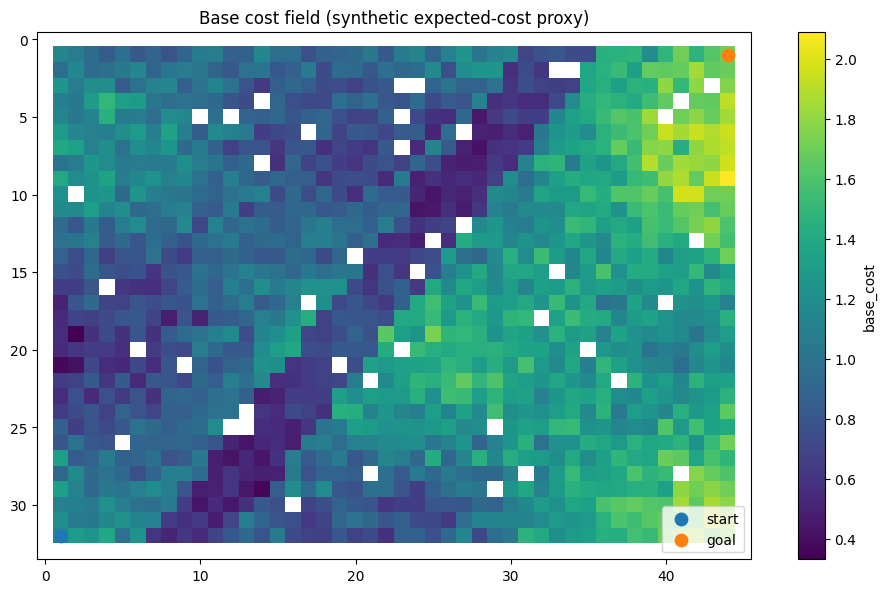

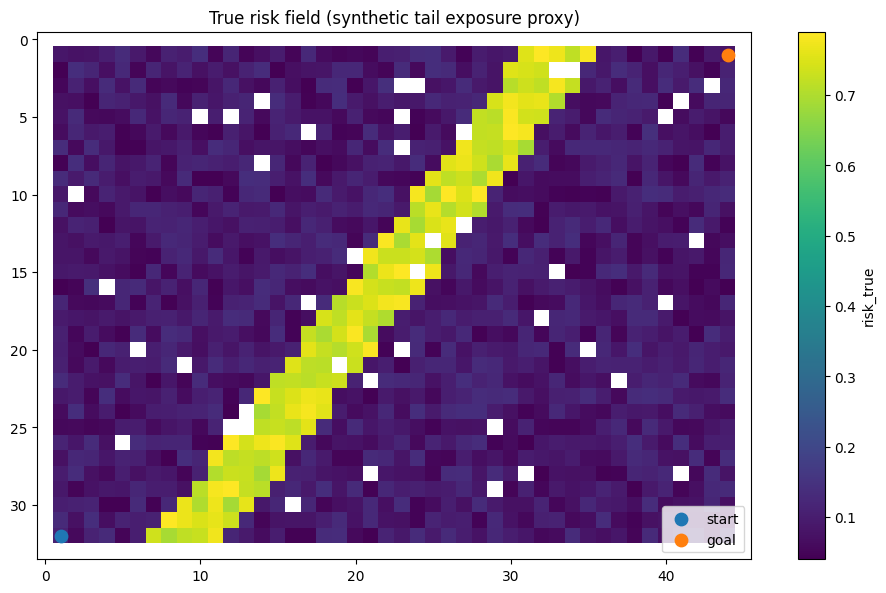

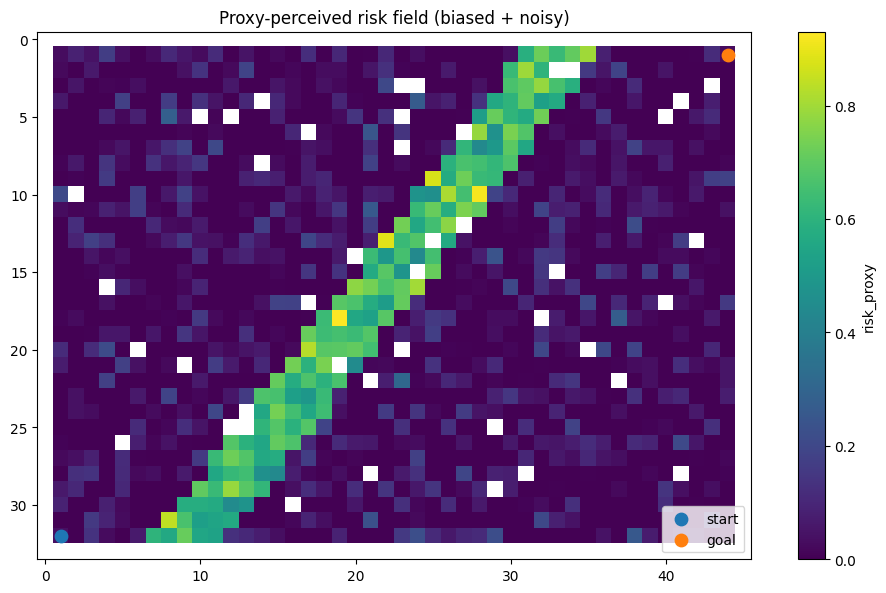

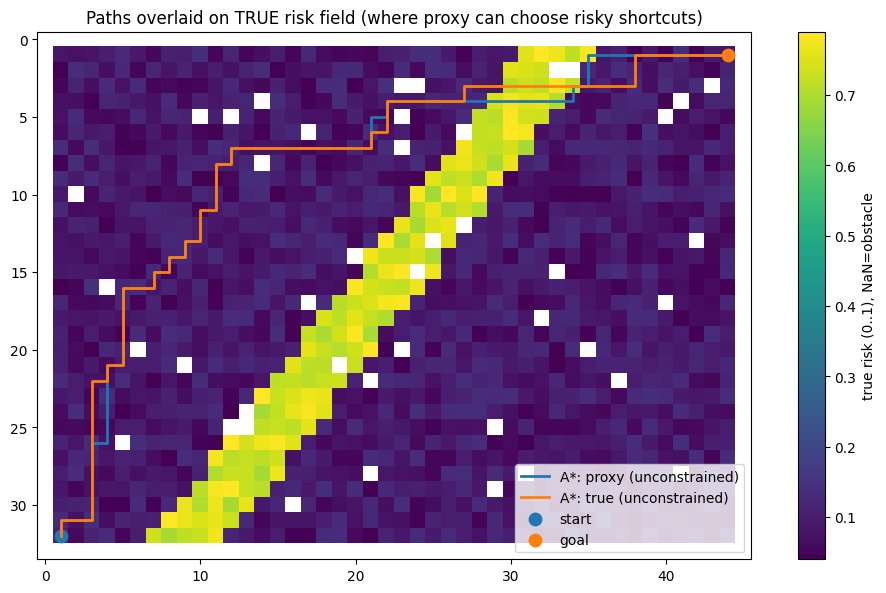

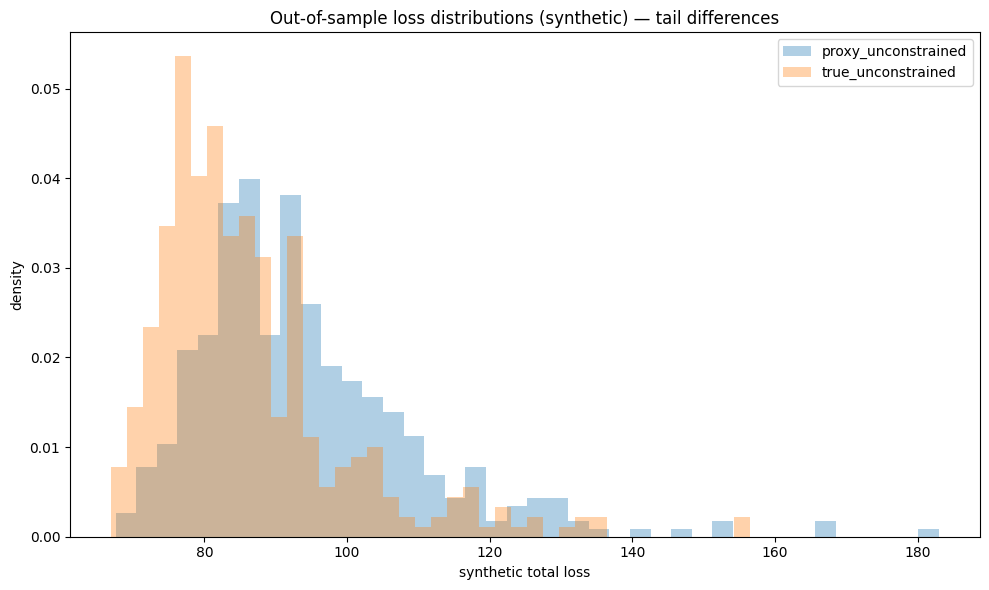

Visualization note: multiple figures are intentional to separate mechanisms cleanly.
Governance note: illustrative, synthetic, and not validated for real-world use.


In [7]:
# CELL 7 — VISUALIZATION PACK: FIELDS + PATH OVERLAYS + OOS LOSS DISTRIBUTIONS (TAIL RISK)

def plot_field(field, title, cmap_label):
    img = field.copy()
    img = img.astype(float)
    img[obstacles] = np.nan
    plt.figure()
    plt.title(title)
    plt.imshow(img, origin="upper")
    plt.colorbar(label=cmap_label)
    plt.scatter([start[1]], [start[0]], s=80, label="start")
    plt.scatter([goal[1]],  [goal[0]],  s=80, label="goal")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

def overlay_paths_on_risk(paths_with_labels, title):
    img = risk_true.copy().astype(float)
    img[obstacles] = np.nan
    plt.figure()
    plt.title(title)
    plt.imshow(img, origin="upper")
    plt.colorbar(label="true risk (0..1), NaN=obstacle")
    for path, label in paths_with_labels:
        if path is None:
            continue
        ys = [s[0] for s in path]
        xs = [s[1] for s in path]
        plt.plot(xs, ys, linewidth=2, label=label)
    plt.scatter([start[1]], [start[0]], s=80, label="start")
    plt.scatter([goal[1]],  [goal[0]],  s=80, label="goal")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

plot_field(base_cost, "Base cost field (synthetic expected-cost proxy)", "base_cost")
plot_field(risk_true, "True risk field (synthetic tail exposure proxy)", "risk_true")
plot_field(risk_proxy, "Proxy-perceived risk field (biased + noisy)", "risk_proxy")

overlay_paths_on_risk(
    [
        (path_proxy_astar, "A*: proxy (unconstrained)"),
        (path_true_astar,  "A*: true (unconstrained)"),
        (path_true_policy, "A*: true + policy"),
    ],
    "Paths overlaid on TRUE risk field (where proxy can choose risky shortcuts)"
)

# OOS loss distributions for key paths
def plot_loss_distributions(paths_dict):
    plt.figure()
    plt.title("Out-of-sample loss distributions (synthetic) — tail differences")
    for label, path in paths_dict.items():
        if path is None:
            continue
        losses = simulate_path_losses(
            path=path,
            n_scenarios=CONFIG["mc_scenarios"],
            shock_scale=CONFIG["shock_scale"],
            seed_offset=hash(label) % 10000
        )
        # Plot as a simple histogram density (interpretable)
        plt.hist(losses, bins=40, alpha=0.35, density=True, label=label)
    plt.xlabel("synthetic total loss")
    plt.ylabel("density")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_loss_distributions({
    "proxy_unconstrained": path_proxy_astar,
    "true_unconstrained":  path_true_astar,
    "true_with_policy":    path_true_policy,
})

print("Visualization note: multiple figures are intentional to separate mechanisms cleanly.")
print("Governance note: illustrative, synthetic, and not validated for real-world use.")


##8.STRESS TEST

###8.1.OVERVIEW

**CELL 8 — Stress Testing: Sensitivity Maps and “Proxy Regret” Under Constraints**

Cell 8 extends the notebook from a single demonstration to a systematic stress test. Rather than showing one pair of plans, it explores how outcomes change as key parameters shift—specifically, the strength of risk aversion and the strictness of the policy threshold. This matters because planning problems often exhibit discontinuities: small parameter adjustments can trigger large changes in the selected trajectory, especially when constraints interact with combinatorial search. In a finance context, this resembles phase-transition behavior: feasibility boundaries and binding constraints can create regime shifts in optimal decisions.

The cell produces two central heatmaps. The first is a map of whether the proxy plan violates policy across the parameter grid. This isolates a governance concern: a plan that looks “fine” under one assumed policy threshold can become unacceptable under a slightly stricter interpretation. The second is a map of “true regret,” comparing the proxy plan to the best feasible plan under the true objective. This is a rigorous diagnostic: it quantifies how costly it is, in true objective terms, to optimize the wrong thing.

Pedagogically, this cell teaches that the danger is not only that the proxy plan is wrong, but that it can be robustly wrong across a wide region of plausible governance settings. If the proxy is systematically misaligned, then searching harder does not fix the issue—it can exacerbate it. The stress test also identifies regions where planning becomes infeasible under tight policy, which is a realistic governance outcome: strict constraints can eliminate all available plans, forcing changes in scope, objectives, or operating envelopes.

Cell 8 is therefore aligned with Chapter 5’s deeper message: constrained planning is not a smooth optimization problem where small adjustments yield small changes. It can be brittle, discontinuous, and highly sensitive to objective and constraint specifications. That sensitivity is exactly why governance must treat specification and evaluation as first-class engineering tasks. Reminder: illustrative, synthetic, and not validated for real-world use.


###8.2.CODE AND IMPLEMENTATION

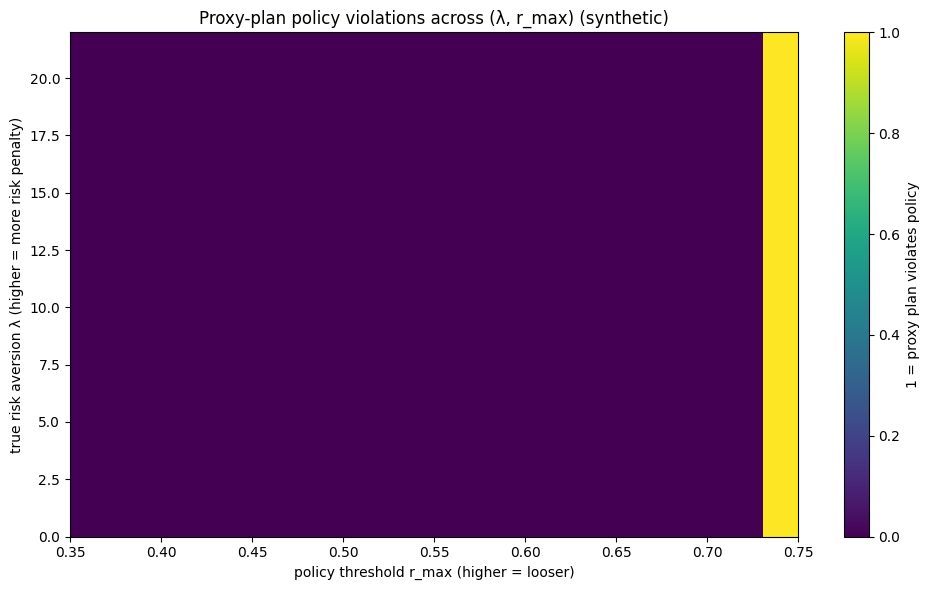

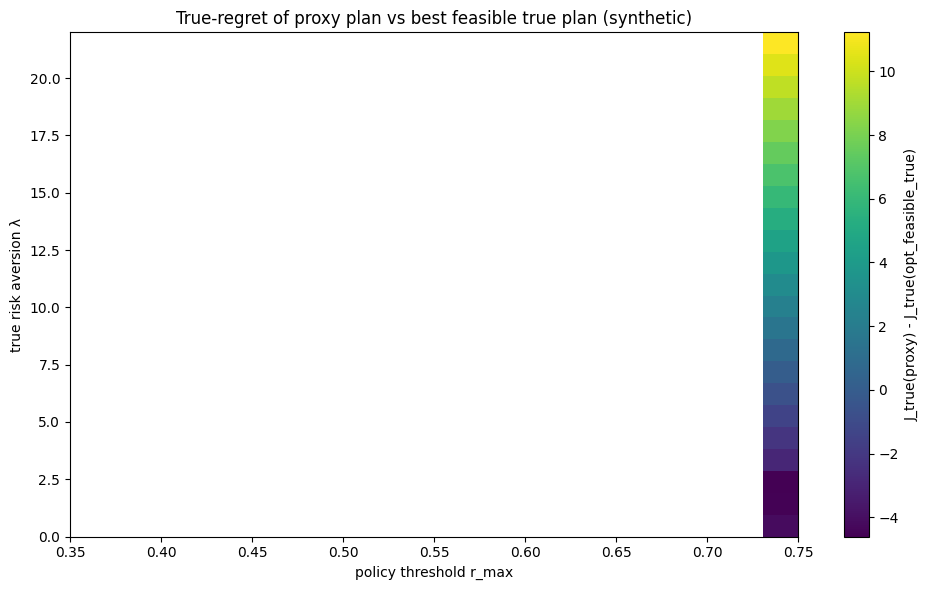

Stress test interpretation (non-advisory): planning introduces discontinuities—small parameter shifts can cause large plan shifts.
Governance note: illustrative, synthetic, and not validated for real-world use.


In [8]:
# CELL 8 — STRESS TEST: OBJECTIVE/CONSTRAINT SENSITIVITY + “SEARCH AMPLIFICATION” REGRET MAPS

# We vary:
# (i) lambda_true (risk aversion in true objective) and (ii) policy threshold r_max_policy,
# then measure:
# - whether proxy-selected plan violates policy
# - true-regret: J_true(proxy_plan) - J_true(best_feasible_true_plan)
#
# This is a finance-style diagnostic: "model risk" from objective misspecification under optimization.

lams = np.linspace(0.0, 22.0, 23)
rmaxs = np.linspace(0.35, 0.75, 21)

violation = np.zeros((len(lams), len(rmaxs)))
regret_true = np.zeros_like(violation)
feasible = np.zeros_like(violation)

# Precompute proxy plan once (the point: search finds a particular loophole under the proxy)
proxy_plan = path_proxy_astar
proxy_sig = None if proxy_plan is None else frozenset(proxy_plan)

def J_true_with_lambda(path, lam):
    if path is None:
        return math.inf
    bc = np.array([base_cost[s] for s in path], dtype=float)
    rc = np.array([risk_true[s] for s in path], dtype=float)
    return float(bc.sum() + float(lam)*np.power(rc, P_TAIL).sum())

for i, lam in enumerate(lams):
    for j, rmax in enumerate(rmaxs):
        # policy gate for this rmax
        pol = (lambda s, rmax=rmax: (not obstacles[s]) and (float(risk_true[s]) <= float(rmax)))

        # best feasible under TRUE objective at this lam
        true_feas_path, _ = a_star(
            start, goal,
            step_cost_fn=(lambda u,v, lam=lam: float(base_cost[v] + float(lam)*(risk_true[v]**P_TAIL))),
            constraint_ok_fn=pol
        )

        feasible[i, j] = 1.0 if true_feas_path is not None else 0.0

        if proxy_plan is None or true_feas_path is None:
            violation[i, j] = 0.0
            regret_true[i, j] = 0.0
            continue

        # proxy plan violation under this rmax
        mxr = float(np.max([risk_true[s] for s in proxy_plan]))
        violation[i, j] = 1.0 if mxr > float(rmax) else 0.0

        # regret in true objective space
        regret_true[i, j] = J_true_with_lambda(proxy_plan, lam) - J_true_with_lambda(true_feas_path, lam)

# Plot violation map
plt.figure()
plt.title("Proxy-plan policy violations across (λ, r_max) (synthetic)")
plt.imshow(violation, origin="lower", aspect="auto",
           extent=[rmaxs.min(), rmaxs.max(), lams.min(), lams.max()])
plt.xlabel("policy threshold r_max (higher = looser)")
plt.ylabel("true risk aversion λ (higher = more risk penalty)")
plt.colorbar(label="1 = proxy plan violates policy")
plt.tight_layout()
plt.show()

# Plot regret map (masked where infeasible)
masked_regret = regret_true.copy()
masked_regret[feasible < 0.5] = np.nan

plt.figure()
plt.title("True-regret of proxy plan vs best feasible true plan (synthetic)")
plt.imshow(masked_regret, origin="lower", aspect="auto",
           extent=[rmaxs.min(), rmaxs.max(), lams.min(), lams.max()])
plt.xlabel("policy threshold r_max")
plt.ylabel("true risk aversion λ")
plt.colorbar(label="J_true(proxy) - J_true(opt_feasible_true)")
plt.tight_layout()
plt.show()

print("Stress test interpretation (non-advisory): planning introduces discontinuities—small parameter shifts can cause large plan shifts.")
print("Governance note: illustrative, synthetic, and not validated for real-world use.")


##9.AUDIT ARTIFACTS

###9.1.0VERVIEW

**CELL 9 — Audit Artifacts: Run Manifest, Traceability, and Result Bundling**

Cell 9 operationalizes governance by producing a concrete audit artifact from the run. In regulated or high-stakes settings, reproducibility and traceability are not “nice to have”; they are requirements. This cell packages the configuration, objective definitions, and results into a structured JSON file. It also includes a configuration hash so that a reviewer can detect whether the experimental setup changed between runs. This is a key governance pattern: interpretability is not only about understanding the model, but about being able to prove what was run.

The artifact includes headline paths (in a compact serialized form) and a multi-metric summary of plan performance. This matters because it separates computational evidence (the trajectories and metrics) from narrative interpretation (which belongs in the final cell). The artifact therefore acts as an intermediate “evidence bundle” that can be inspected independently. A reviewer can verify that the notebook produced certain trajectories and metrics without relying on any language model summary.

Importantly, the cell encodes the objective specification explicitly. This is aligned with Chapter 5’s theme: many planning failures arise not from algorithmic mistakes but from specification drift—small edits to objectives or constraints that later become institutional facts. By saving the objective spec, the notebook prevents that drift from being invisible. The cell also stores limitations and interpretive notes in a disciplined way, making it harder for later readers to treat the results as real-world evidence.

This is exactly what a governance-first notebook should do: it produces an auditable record of a synthetic demonstration so that interpretation can be anchored to artifacts rather than memory. Cell 9 is the bridge between the computational experiment and the final interpretive report. Reminder: illustrative, synthetic, and not validated for real-world use.


###9.2.CODE AND IMPLEMENTATION

In [9]:
# CELL 9 — PROFESSIONAL AUDIT ARTIFACTS: RUN MANIFEST + RESULTS BUNDLE (JSON) + MINIMAL TRACEABILITY

RUN_ID = f"paper5_planning_synth_{int(time.time())}"
out_dir = "/tmp/paper5_notebook_outputs"
os.makedirs(out_dir, exist_ok=True)

def serialize_path(path):
    if path is None:
        return None
    return [{"i": int(s[0]), "j": int(s[1])} for s in path]

# Choose a compact set of “headline” plans for artifacts
headline = {
    "proxy_unconstrained_A*": serialize_path(path_proxy_astar),
    "true_unconstrained_A*":  serialize_path(path_true_astar),
    "true_with_policy_A*":    serialize_path(path_true_policy),
    "proxy_beam":             serialize_path(path_proxy_beam),
}

artifact = {
    "run_id": RUN_ID,
    "timestamp_unix": int(time.time()),
    "config": CONFIG,
    "config_hash_sha256": stable_hash(CONFIG),
    "governance_disclaimer": "Illustrative, synthetic, NOT validated for real-world use. No advice.",
    "objective_spec": {
        "proxy": "sum(base_cost) + w_proxy*sum(risk_proxy^p)",
        "true":  "sum(base_cost) + lambda_true*sum(risk_true^p)",
        "policy": "max_t risk_true(s_t) <= r_max_policy",
        "oos_loss_model": "base_cost sum + shocks with prob=risk_true; severity ~ shock_scale*(risk_true^p)*LogNormal(0,1)",
        "tail_metric": f"CVaR@{CONFIG['cvar_alpha']}",
    },
    "results_summaries": reports,
    "headline_paths": headline,
    "notes": {
        "interpretation": [
            "Search amplifies objective misspecification by locating proxy-optimal loopholes.",
            "Policy constraints change feasible sets and can flip the selected plan.",
            "Multi-metric evaluation (including tail metrics) is required to audit plan quality."
        ],
        "limitations": [
            "Synthetic grid; no real market microstructure; no calibration; no forecasting.",
            "Risk model is illustrative; shock process is synthetic."
        ]
    }
}

artifact_path = os.path.join(out_dir, "run_artifact.json")
with open(artifact_path, "w") as f:
    json.dump(artifact, f, indent=2, sort_keys=True)

print(f"Saved audit artifact: {artifact_path}")
print(f"Artifact size (bytes): {os.path.getsize(artifact_path)}")
print("Governance note: illustrative, synthetic, and not validated for real-world use.")


Saved audit artifact: /tmp/paper5_notebook_outputs/run_artifact.json
Artifact size (bytes): 15538
Governance note: illustrative, synthetic, and not validated for real-world use.


##10.AUDIT REPORT

###10.1.OVERVIEW

**CELL 10 — LLM-Generated Audit Report: Interpretation Without Changing the Evidence**

Cell 10 is designed to generate a professional, audit-style narrative that interprets the experiment using only the evidence produced in earlier cells—especially the JSON artifact from Cell 9. This structure is essential for governance. It creates a strict separation of concerns: Cells 1–9 define the environment, produce trajectories, compute metrics, and save the results; Cell 10 produces an interpretive report that cannot affect the computation. That separation is what makes the notebook defensible. A reviewer can rerun the notebook, compare artifacts, and evaluate whether the narrative is faithful to the evidence.

The cell is “LLM-first and fail-loud.” That is a deliberate governance choice: it prevents silent fallbacks that might lead an operator to believe the report came from the model when it did not. If the API key is missing or the call fails, the cell explicitly errors, which forces the user to confront the state of the system. When the call succeeds, the cell prints a clear indication that it is calling the named model, and then prints the model output. This transparency is critical for audit contexts, because provenance of narrative text matters.

The report produced by the model is constrained: it must be non-advisory, synthetic-only, and grounded in the payload. The structure of the report mirrors professional model-risk communication: executive mechanism summary, objective and constraint specification, findings with comparisons, tail-risk interpretation, governance implications framed as conceptual controls rather than prescriptions, and explicit limitations. This aligns with Chapter 5’s core emphasis: the planner is an amplifier of specification, so governance must focus on objective clarity, constraint enforcement, and evaluation discipline.

Cell 10 therefore serves as the “interpretation layer” of the notebook—valuable for comprehension, but deliberately constrained and auditable. The narrative is not treated as truth; it is treated as a structured interpretation of synthetic evidence. Reminder: illustrative, synthetic, and not validated for real-world use.


###10.2.CODE AND IMPLEMENTATION

In [11]:
# CELL 10 — LLM-FIRST INTELLIGENT AUDIT REPORT (FAIL-LOUD IF NOT RUNNING THE LLM)
#
# This cell will:
# 1) Load the synthetic run artifact from Cell 9
# 2) Build a structured audit payload
# 3) CALL Claude Haiku (claude-haiku-4-5-20251001) to draft an audit report
# 4) Print the LLM report + a compact local appendix for traceability
#
# Governance note: illustrative, synthetic, NOT validated for real-world use. No advice.

import os, json, time, hashlib, math
import numpy as np

# --- 0) Ensure Anthropic SDK is available (Colab-safe) ---
try:
    import anthropic
except Exception as e:
    print("Anthropic SDK not found or import failed. Installing 'anthropic' ...")
    !pip -q install anthropic
    import anthropic

from google.colab import userdata

MODEL_NAME = "claude-haiku-4-5-20251001"
ARTIFACT_PATH = "/tmp/paper5_notebook_outputs/run_artifact.json"

def stable_hash(obj) -> str:
    b = json.dumps(obj, sort_keys=True).encode("utf-8")
    return hashlib.sha256(b).hexdigest()

def safe_read_json(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing artifact at: {path}. Run Cell 9 first.")
    with open(path, "r") as f:
        return json.load(f)

artifact = safe_read_json(ARTIFACT_PATH)

# --- 1) Local structured findings (deterministic) used as “ground truth hints” for the LLM ---
cfg = artifact["config"]
reports = artifact["results_summaries"]

def pick(d, key, default=None):
    return d[key] if (d is not None and key in d) else default

def fmt(x, nd=4):
    if x is None:
        return "NA"
    if isinstance(x, bool):
        return str(x)
    try:
        return f"{float(x):.{nd}f}"
    except Exception:
        return str(x)

def find_by_substring(sub):
    for r in reports:
        if sub in r.get("name", ""):
            return r
    return None

proxy_u = find_by_substring("A*_proxy_unconstrained")
true_u  = find_by_substring("A*_true_unconstrained")
true_p  = find_by_substring("A*_true_with_policy")

contrasts = []
if proxy_u and true_u:
    contrasts.append({
        "contrast": "Proxy vs True (unconstrained)",
        "proxy_max_risk": pick(proxy_u, "max_risk_true"),
        "true_max_risk":  pick(true_u, "max_risk_true"),
        "proxy_CVaR":     pick(proxy_u, f"OOS_CVaR_a{int(cfg['cvar_alpha']*100)}"),
        "true_CVaR":      pick(true_u,  f"OOS_CVaR_a{int(cfg['cvar_alpha']*100)}"),
        "proxy_policy_violates": pick(proxy_u, "policy_violates"),
        "true_policy_violates":  pick(true_u,  "policy_violates"),
    })
if proxy_u and true_p:
    contrasts.append({
        "contrast": "Proxy unconstrained vs True with policy",
        "proxy_max_risk": pick(proxy_u, "max_risk_true"),
        "policy_r_max": cfg["r_max_policy"],
        "true_policy_max_risk": pick(true_p, "max_risk_true"),
        "proxy_CVaR": pick(proxy_u, f"OOS_CVaR_a{int(cfg['cvar_alpha']*100)}"),
        "true_policy_CVaR": pick(true_p, f"OOS_CVaR_a{int(cfg['cvar_alpha']*100)}"),
    })

payload = {
    "run_id": artifact.get("run_id"),
    "config": artifact.get("config"),
    "objective_spec": artifact.get("objective_spec"),
    "results_summaries": artifact.get("results_summaries"),
    "headline_paths_present": list((artifact.get("headline_paths") or {}).keys()),
    "local_structured_findings": {
        "contrasts": contrasts,
        "config_hash": artifact.get("config_hash_sha256"),
        "governance_disclaimer": artifact.get("governance_disclaimer"),
    }
}

llm_prompt = (
    "You are drafting an audit-style technical report for senior finance / model-risk / governance practitioners.\n"
    "This is a SYNTHETIC controlled experiment illustrating a mechanism: planning/search amplifies objective mis-specification, and constraints can flip the optimal plan.\n"
    "Hard requirements:\n"
    "1) State clearly: synthetic, illustrative, NOT validated for real-world use.\n"
    "2) No advice, no recommendations, no deployment claims.\n"
    "3) Do not invent facts beyond the JSON payload.\n"
    "4) Use finance-grade framing: objective specification, constraint feasibility, tail risk, VaR/CVaR interpretation, model risk controls.\n\n"
    "Produce exactly these sections (with headings):\n"
    "1) Executive summary (mechanism-level)\n"
    "2) Methods and objective specification\n"
    "3) Findings (proxy vs true vs policy-constrained)\n"
    "4) Tail-risk assessment (OOS VaR/CVaR)\n"
    "5) Governance and control implications (non-advisory)\n"
    "6) Limitations and validation requirements\n\n"
    "JSON payload:\n"
    + json.dumps(payload, indent=2, sort_keys=True)
)

# --- 2) FAIL-LOUD KEY CHECK (so it never silently “doesn’t use the LLM”) ---
api_key = userdata.get("ANTHROPIC_API_KEY")
if not api_key or not isinstance(api_key, str) or len(api_key.strip()) < 10:
    raise RuntimeError(
        "ANTHROPIC_API_KEY is missing/invalid in Colab userdata. "
        "Set it in Colab (Runtime → Secrets / user data) as key: ANTHROPIC_API_KEY, then re-run Cell 10."
    )

# --- 3) CALL THE LLM (explicitly) ---
print("=" * 100)
print(f"CALLING ANTHROPIC MODEL: {MODEL_NAME}")
print(f"Run ID: {artifact.get('run_id')} | Config hash: {(artifact.get('config_hash_sha256') or '')[:16]}...")
print("=" * 100)

client = anthropic.Anthropic(api_key=api_key)

msg = client.messages.create(
    model=MODEL_NAME,
    max_tokens=1600,
    temperature=0.2,
    messages=[{"role": "user", "content": llm_prompt}]
)

# Extract text blocks robustly
text_parts = []
for block in msg.content:
    if getattr(block, "type", None) == "text":
        text_parts.append(block.text)

llm_report = "\n".join(text_parts).strip()

print("\n" + "=" * 100)
print("LLM-GENERATED AUDIT REPORT (SYNTHETIC; NOT VALIDATED; NON-ADVISORY)")
print("=" * 100)
print(llm_report)

# --- 4) Deterministic appendix for traceability (compact) ---
print("\n" + "=" * 100)
print("APPENDIX — LOCAL TRACEABILITY SNAPSHOT (DETERMINISTIC)")
print("=" * 100)
print("Selected contrasts:")
for c in contrasts:
    print(f"- {c['contrast']}")
    for k, v in c.items():
        if k == "contrast":
            continue
        print(f"    {k}: {fmt(v)}")
print("\nReminder: illustrative, synthetic, and NOT validated for real-world use.")


Anthropic SDK not found or import failed. Installing 'anthropic' ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 8.8 MB/s eta 0:00:00
CALLING ANTHROPIC MODEL: claude-haiku-4-5-20251001
Run ID: paper5_planning_synth_1770381207 | Config hash: e26fb76c6974eeb4...

LLM-GENERATED AUDIT REPORT (SYNTHETIC; NOT VALIDATED; NON-ADVISORY)
# TECHNICAL AUDIT REPORT
## Planning Search, Objective Mis-specification, and Constraint Feasibility
**Synthetic Illustrative Experiment**

---

## 1. Executive Summary (Mechanism-Level)

This report documents a **synthetic, controlled experiment** designed to isolate one mechanism: how planning/search depth amplifies the consequences of objective mis-specification, and how hard constraints can flip the optimal plan topology.

**Key Observations (Illustrative Only):**

- **Proxy vs. True Objective Divergence:** When a planning algorithm optimizes a proxy objective (biased risk model, weight=0.0) without constraint enforcement, it produces plans wi

##11.CONCLUSION

**CONCLUSION — What the Experiment Establishes and How to Read It (Governance-First)**

The experiment in this notebook establishes a mechanism rather than a result. That distinction is the central governance lesson. In a real system, one might be tempted to interpret an “optimal plan” as evidence of competence. This notebook shows why that inference is unsafe. A planner can be highly competent and still generate unacceptable outcomes if the objective and constraints are misspecified. The planner is not a moral agent and it is not a risk committee. It is an optimizer. Chapter 5’s claim—that planning and search amplify objective mis-specification—is not a philosophical caution; it is a structural property of optimization under constraints.

The notebook’s synthetic environment was designed to make that property visible. The decision landscape contained two competing realities: a base cost field that rewards efficiency in expectation and a true risk field that encodes tail exposure. The crucial element was the corridor where these two realities diverge: a region that is cheap under the proxy metric but hazardous under the true risk model. The corridor is not intended to represent any specific market microstructure phenomenon. Its purpose is to represent a general class of situations where first-moment efficiency and tail exposure are not aligned. In finance and enterprise systems, those divergences are common: compliance constraints, operational fragility, correlated hazards, and rare events tend to be invisible to average cost metrics until they matter.

When the planner optimizes the proxy objective, it predictably discovers the corridor. This is the key amplification effect. The planner is not “making a mistake.” It is succeeding. It is demonstrating that search procedures can locate and exploit the best-scoring solutions under the objective you provided. If the proxy objective does not meaningfully penalize tail exposure—because risk is ignored, underweighted, or measured with biased noise—then the corridor becomes a rational target. This is why better planning capability increases governance stakes: it increases the system’s ability to discover and commit to proxy loopholes. In that sense, planning converts a small specification error into a large trajectory error.

The notebook then demonstrates a second, equally important property: constraints change optimality by changing feasibility. When a hard policy gate is imposed—here, a maximum allowed risk threshold—plans that would otherwise be “optimal” become invalid. The planner must route around forbidden states, potentially accepting higher base costs to remain compliant. This is a faithful representation of governance in real organizations. Policy is not a soft preference. If a plan violates a regulatory rule, a mandate, or a safety boundary, it is not a “high-cost plan.” It is an unacceptable plan. The notebook’s constrained planner shows the structural consequence: different feasibility implies different optima. Therefore, in planning systems, governance is not a layer applied after optimization; it is a definition of the feasible set that must be integrated into planning itself.

A finance-trained reader will immediately recognize that the most important divergences often occur in tail behavior. That is why the notebook’s evaluation does not stop at in-sample objective values. It introduces an out-of-sample synthetic loss mechanism, deliberately designed to produce heavy-tailed outcomes when shocks occur in high-risk states. This is not meant to be a market model. It is meant to expose a governance-relevant truth: mean performance and tail performance can be decoupled. A proxy-optimal plan can look attractive under average cost while embedding a much larger right tail of losses. By computing tail summaries akin to VaR and CVaR, the notebook makes this visible. If a reader sees only the proxy objective, they might believe the planner found a superior strategy. If they also see CVaR, they see that the same “superior” strategy is fragile in precisely the way governance cares about.

The sensitivity analysis deepens the lesson. Constrained combinatorial problems often display discontinuities: small changes in parameters can yield large changes in the chosen plan. The notebook’s heatmaps show regions where the proxy plan violates policy under plausible thresholds and regions where the proxy plan experiences large regret under the true objective compared to the best feasible plan. This is a model-risk diagnostic pattern. It shifts attention from point estimates (“here is the best plan”) to robustness questions (“how stable is this plan under plausible governance regimes?”). In real systems, many failures occur when organizations treat objective specifications and policy thresholds as fixed truths rather than as uncertain, revisable artifacts. Sensitivity maps reveal that the chosen trajectory is a function of these specifications; change the specification slightly and you may obtain a qualitatively different plan.

From a governance-first perspective, the notebook’s most consequential design decision is not the planner itself. It is the separation between evidence and interpretation. The notebook exports an audit artifact containing the configuration, objectives, metrics, and headline trajectories. This makes the experiment inspectable independently of narrative. The final interpretive report—whether written by a human or drafted by a language model—is then constrained to describe only what is in that artifact. This pattern addresses a core risk of modern AI workflows: narrative outputs can drift away from evidence. By forcing interpretation to be grounded in a structured payload, the notebook reduces the chance that persuasive language replaces traceable facts.

The final cell’s LLM-generated report is therefore best read as a standardized narrative wrapper, not as an authority. Its value is consistency and clarity: it can describe the mechanism, highlight divergences, and state limitations in a professional audit style. Its danger, if unconstrained, would be overreach—adding claims not supported by the data. That is why the notebook’s design insists on governance constraints in the prompt: synthetic only, no advice, no invented metrics, and explicit limitations. The result is an interpretive artifact that can support teaching, discussion, and governance awareness without implying deployability.

The broader implication for Chapter 5 is straightforward and severe. Planning and search shift the center of gravity from “how accurate is the model” to “how correct is the specification.” In a one-step setting, mis-specification can be costly. In a multi-step planning setting, mis-specification can be amplified into a trajectory that repeatedly chooses the wrong trade-offs, accumulates hidden fragility, and violates constraints. Stronger planners increase the importance of objective discipline and constraint clarity. Tail-aware evaluation becomes mandatory because governance failures are often tail failures. And audit artifacts become essential because interpretation without provenance is not governance—it is rhetoric.

This notebook does not claim that planning systems are unusable. It claims something more precise: planning systems are as safe and as aligned as the objectives and constraints they are given, and search capability increases the consequences of mistakes. That is the professional takeaway. The experiment is synthetic, illustrative, and not validated for real-world use, but the mechanism it exposes is structural and worth treating as a first-class governance concern.
